# Adding error to OTU count values

* Drawing from a distribution that simulates error in count data
  * For instance: over-dispersion (negative binomial)

# Setting variables

In [263]:
# dirs
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/PCR_sim/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# input files
OTU_table_file = os.path.join(workDir, 'OTU_abs1e9.txt')

# params
nprocs = 24

# Init

In [264]:
import numpy as np
import matplotlib.pyplot as plt

In [265]:
%load_ext rpy2.ipython
%matplotlib inline  

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [266]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

# Testing distribution functions

### Modeling in R

In [320]:
%%R
NegBin = function(mu, alpha=0.5, n=1) {
    mu = mu * rgamma(n, shape = alpha, scale=alpha) #rate = 1/alpha)
    rpois(n, lambda = mu)
}

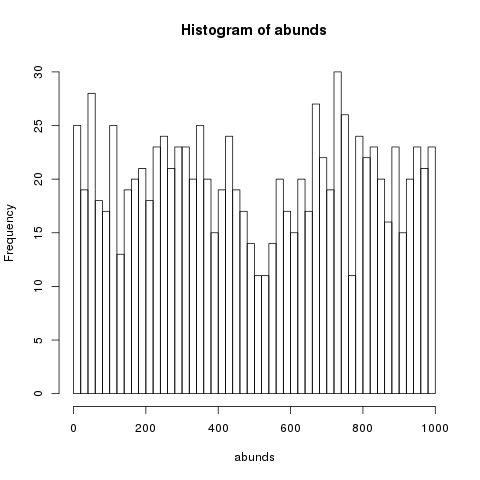

In [248]:
%%R
# taxon abundances
abunds = runif(1000, min=1, max=1000)
hist(abunds, 50)

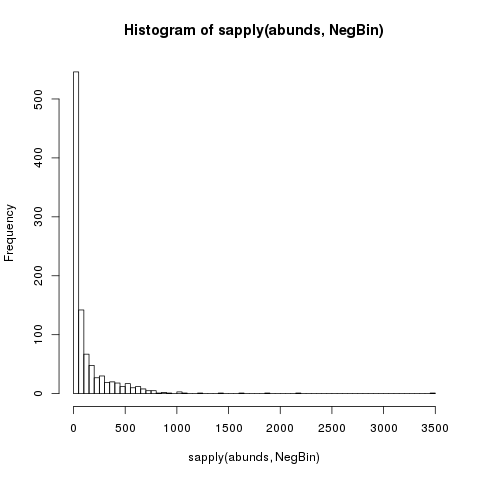

In [249]:
%%R
hist(sapply(abunds, NegBin), 50)

In [250]:
%%R
# abunds with error: repeating count draw many times to increase variance estimation
alpha = 0.1
NegBin.a = function(x){
    NegBin(x, alpha=alpha)
}

abund.l = list()
for (i in 1:1000){
    abund.l[[i]] = sapply(abunds, NegBin.a)
    }
abund.e = do.call(rbind, abund.l) %>%
    as.data.frame %>% t
var.e = apply(abund.e, 1, var) %>% as.vector
var.e %>% head

[1]  17.89898 174.11652 510.73830   7.64625  31.38903 180.54050


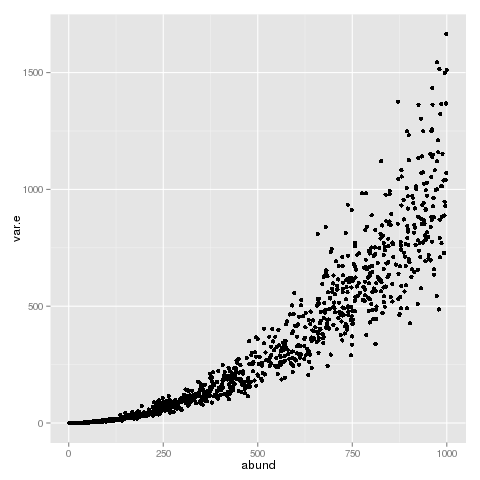

In [251]:
%%R
df = data.frame(abund = abunds, var.e = var.e)
ggplot(df, aes(abund, var.e)) +
    geom_point()

In [252]:
%%R
# abunds with error: repeating count draw many times to increase variance estimation
alpha = 0.5
NegBin.a = function(x){
    NegBin(x, alpha=alpha)
}

abund.l = list()
for (i in 1:1000){
    abund.l[[i]] = sapply(abunds, NegBin.a)
    }
abund.e = do.call(rbind, abund.l) %>%
    as.data.frame %>% t
var.e = apply(abund.e, 1, var) %>% as.vector
var.e %>% head

[1]   1678.727  27276.143 117199.021   1463.502   4276.306  19977.746


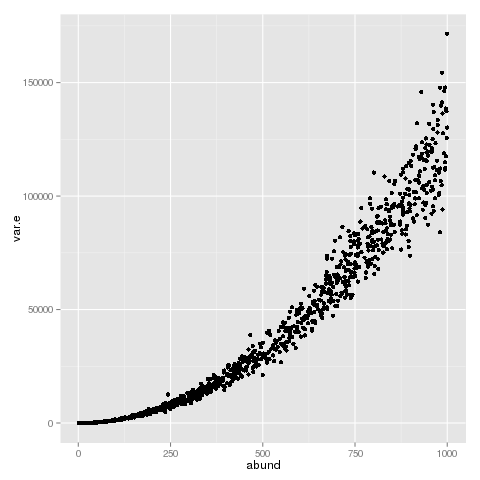

In [253]:
%%R
df = data.frame(abund = abunds, var.e = var.e)
ggplot(df, aes(abund, var.e)) +
    geom_point()

In [254]:
%%R
# abunds with error: repeating count draw many times to increase variance estimation
alpha = 10
NegBin.a = function(x){
    NegBin(x, alpha=alpha)
}

abund.l = list()
for (i in 1:1000){
    abund.l[[i]] = sapply(abunds, NegBin.a)
    }
abund.e = do.call(rbind, abund.l) %>%
    as.data.frame %>% t
var.e = apply(abund.e, 1, var) %>% as.vector
var.e %>% head

[1]  12262909 215725167 871203383  11086432  31895701 140438396


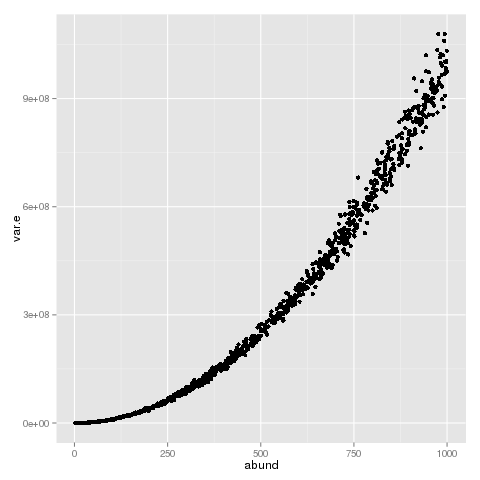

In [255]:
%%R
df = data.frame(abund = abunds, var.e = var.e)
ggplot(df, aes(abund, var.e)) +
    geom_point() 

### Modeling in python

In [310]:
def neg_binom(mu, alpha=0.5, size=None):
    mu = mu * np.random.gamma(shape=alpha, scale=alpha, size=size)
    f = lambda x: np.random.poisson(size=1, lam=x)[0]
    return [f(x) for x in mu]

(array([ 11.,  27.,  17.,  17.,  17.,  17.,  22.,  16.,  13.,  26.,  19.,
         15.,  20.,  14.,  19.,  13.,  22.,  28.,  19.,  18.,  21.,  21.,
         23.,  11.,  18.,  24.,  21.,  26.,  20.,  17.,  27.,  24.,  22.,
         14.,  20.,  20.,  29.,  27.,  23.,  18.,  23.,  19.,  19.,  11.,
         19.,  25.,  25.,  13.,  24.,  26.]),
 array([   1.61623873,   21.5696432 ,   41.52304767,   61.47645213,
          81.4298566 ,  101.38326107,  121.33666553,  141.29007   ,
         161.24347447,  181.19687893,  201.1502834 ,  221.10368786,
         241.05709233,  261.0104968 ,  280.96390126,  300.91730573,
         320.8707102 ,  340.82411466,  360.77751913,  380.7309236 ,
         400.68432806,  420.63773253,  440.591137  ,  460.54454146,
         480.49794593,  500.45135039,  520.40475486,  540.35815933,
         560.31156379,  580.26496826,  600.21837273,  620.17177719,
         640.12518166,  660.07858613,  680.03199059,  699.98539506,
         719.93879953,  739.89220399,  759.845

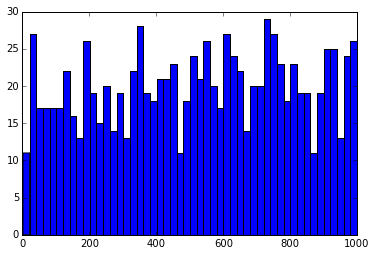

In [224]:
counts = np.random.uniform(1000, 1, 1000)
plt.hist(counts, 50)

In [260]:
n_counts = len(counts)
n_rep = 1000
alpha = 0.1
ar = np.zeros((n_rep, n_counts))
neg_binom_a = lambda x : neg_binom(x, alpha=alpha)
for i in range(n_rep):
    ar[i,] = np.apply_along_axis(neg_binom_a, 0, counts)

counts_var = np.var(ar, 0)

(0, 919.84718399997769)

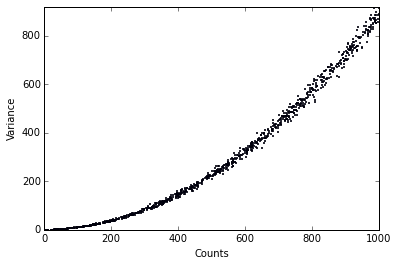

In [261]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(counts, counts_var, s=1)
xl = ax.set_xlabel("Counts")
yl = ax.set_ylabel("Variance")
ax.set_xlim([0,np.max(counts)])
ax.set_ylim([0,np.max(counts_var)])

In [256]:
n_counts = len(counts)
n_rep = 1000
alpha = 0.5
ar = np.zeros((n_rep, n_counts))
neg_binom_a = lambda x : neg_binom(x, alpha=alpha)
for i in range(n_rep):
    ar[i,] = np.apply_along_axis(neg_binom_a, 0, counts)

counts_var = np.var(ar, 0)

(0, 115118.56703599979)

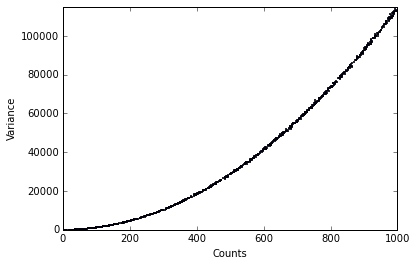

In [257]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(counts, counts_var, s=1)
xl = ax.set_xlabel("Counts")
yl = ax.set_ylabel("Variance")
ax.set_xlim([0,np.max(counts)])
ax.set_ylim([0,np.max(counts_var)])

In [258]:
n_counts = len(counts)
n_rep = 1000
alpha = 10
ar = np.zeros((n_rep, n_counts))
neg_binom_a = lambda x : neg_binom(x, alpha=alpha)
for i in range(n_rep):
    ar[i,] = np.apply_along_axis(neg_binom_a, 0, counts)

counts_var = np.var(ar, 0)

(0, 1043632103.6068968)

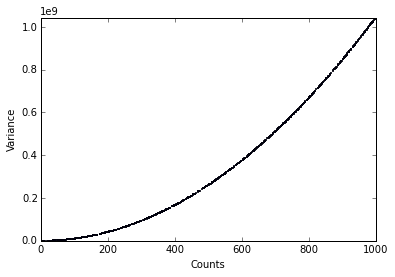

In [259]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(counts, counts_var, s=1)
xl = ax.set_xlabel("Counts")
yl = ax.set_ylabel("Variance")
ax.set_xlim([0,np.max(counts)])
ax.set_ylim([0,np.max(counts_var)])

# Adding error

In [304]:
!cd $workDir; \
    SIPSim OTU_add_error \
    OTU_abs1e9.txt \
    > OTU_abs1e9_err.txt
    
!cd $workDir; \
    head -n 4 OTU_abs1e9_err.txt

library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Clostridium_ljungdahlii_DSM_13528	1.660-1.664	1.66	1.662	1.664	0	0.0
1	Clostridium_ljungdahlii_DSM_13528	1.664-1.669	1.664	1.667	1.669	17013	0.9915491316
1	Clostridium_ljungdahlii_DSM_13528	1.669-1.672	1.669	1.671	1.672	39	1.0


In [298]:
%%R -i workDir 
setwd(workDir) 

tbl.otu = read.delim('OTU_abs1e9_err.txt', sep='\t')
tbl.otu %>% head(n=3)

  library                             taxon    fraction BD_min BD_mid BD_max
1       1 Clostridium_ljungdahlii_DSM_13528 1.660-1.664  1.660  1.662  1.664
2       1 Clostridium_ljungdahlii_DSM_13528 1.664-1.669  1.664  1.667  1.669
3       1 Clostridium_ljungdahlii_DSM_13528 1.669-1.672  1.669  1.671  1.672
  count rel_abund
1     0 0.0000000
2  8207 0.4301814
3  1638 1.0000000


In [299]:
%%R

tbl.otu.g = tbl.otu %>%
    gather(abund_type, value, count, rel_abund)

tbl.otu.g %>% head(n=3)

  library                             taxon    fraction BD_min BD_mid BD_max
1       1 Clostridium_ljungdahlii_DSM_13528 1.660-1.664  1.660  1.662  1.664
2       1 Clostridium_ljungdahlii_DSM_13528 1.664-1.669  1.664  1.667  1.669
3       1 Clostridium_ljungdahlii_DSM_13528 1.669-1.672  1.669  1.671  1.672
  abund_type value
1      count     0
2      count  8207
3      count  1638


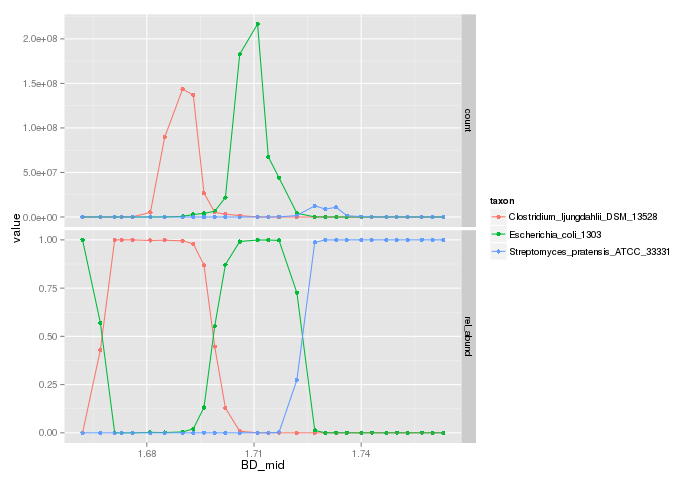

In [300]:
%%R -w 700

ggplot(tbl.otu.g, aes(BD_mid, value, fill=taxon, color=taxon)) +
    geom_point() +
    geom_line() +
    #geom_area(position='fill', alpha=0.5) +
    facet_grid(abund_type ~ ., scales='free_y')